# Calculate mean hot water usage per week day and hour

Water usage is identified as the negative derivative of water temperature. If hot water is used, the water temperature of the boiler is reduced by a significant level. This temperature fall can be used as indicator of hot water usage. This method is not perfect, so if the heating system heats up the water and at the same time hot water is being used, this usage can not be measured.

In [396]:
from influxdb import InfluxDBClient
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [397]:
host = %env INFLUXDB_HOST
user = %env INFLUXDB_USER
password = %env INFLUXDB_PASSWORD
database = %env INFLUXDB_DATABASE
hot_water_measurement = "heating_system_hot_water_temp"

In [398]:
client = InfluxDBClient(host=host, username=user, password=password, database=database);

(f'(x) - abs(f'(x))) / 2 --> negative second derivative

In [399]:
#results = client.query('SELECT (derivative( "value", 10s) - abs(derivative( "value", 10s))) / -2 as derivate FROM ' + hot_water_measurement + " where time >= '2022-09-07 00:00:00' and time < '2022-09-08 00:00:00'")
results = client.query('SELECT (derivative( "value", 10s) - abs(derivative( "value", 10s))) / -2 as derivate FROM ' + hot_water_measurement)
points = results.get_points()

Calculate usage by hour and weekday to find optimal weekly operation times for water boiler. Increase counter if derivation is above threshold.

In [400]:
usage_by_hour_and_weekday = [0 for i in range(24 * 7)]
usage_derivation_threshold = 0.08
usage_impulse = False;
for point in points:
    if len(point['time']) == 20:
        date = datetime.strptime(point['time'], '%Y-%m-%dT%H:%M:%SZ') + timedelta(hours=2)
    else:
        date = datetime.strptime(point['time'], '%Y-%m-%dT%H:%M:%S.%fZ') + timedelta(hours=2)
    index = date.weekday() * 24 + date.hour;
    if point['derivate'] > usage_derivation_threshold and not usage_impulse:
        usage_impulse = True
        usage_by_hour_and_weekday[index] += 1
    elif point['derivate'] <= usage_derivation_threshold:
        usage_impulse = False # end of usage impulse

Plot warm water usage by weekday

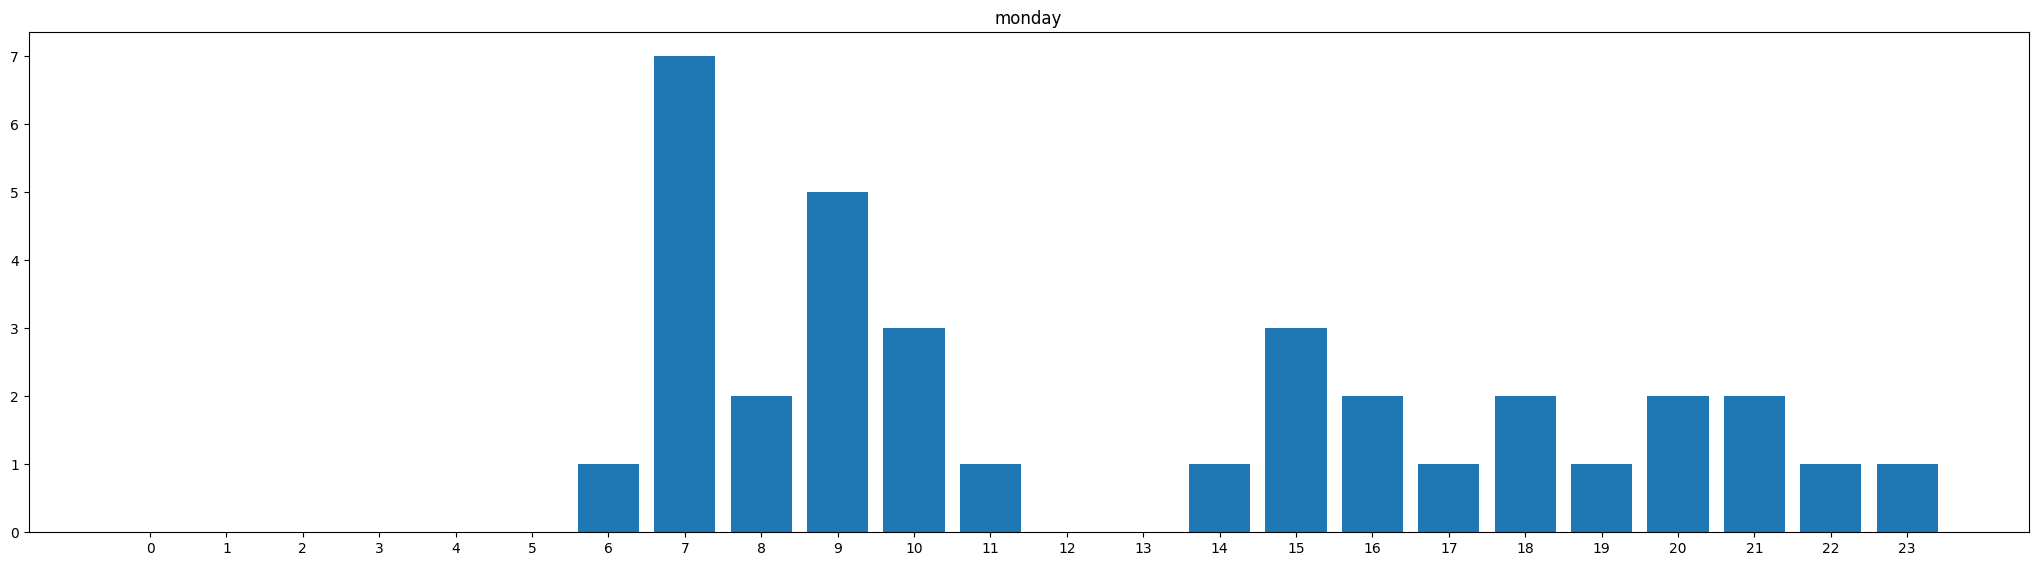

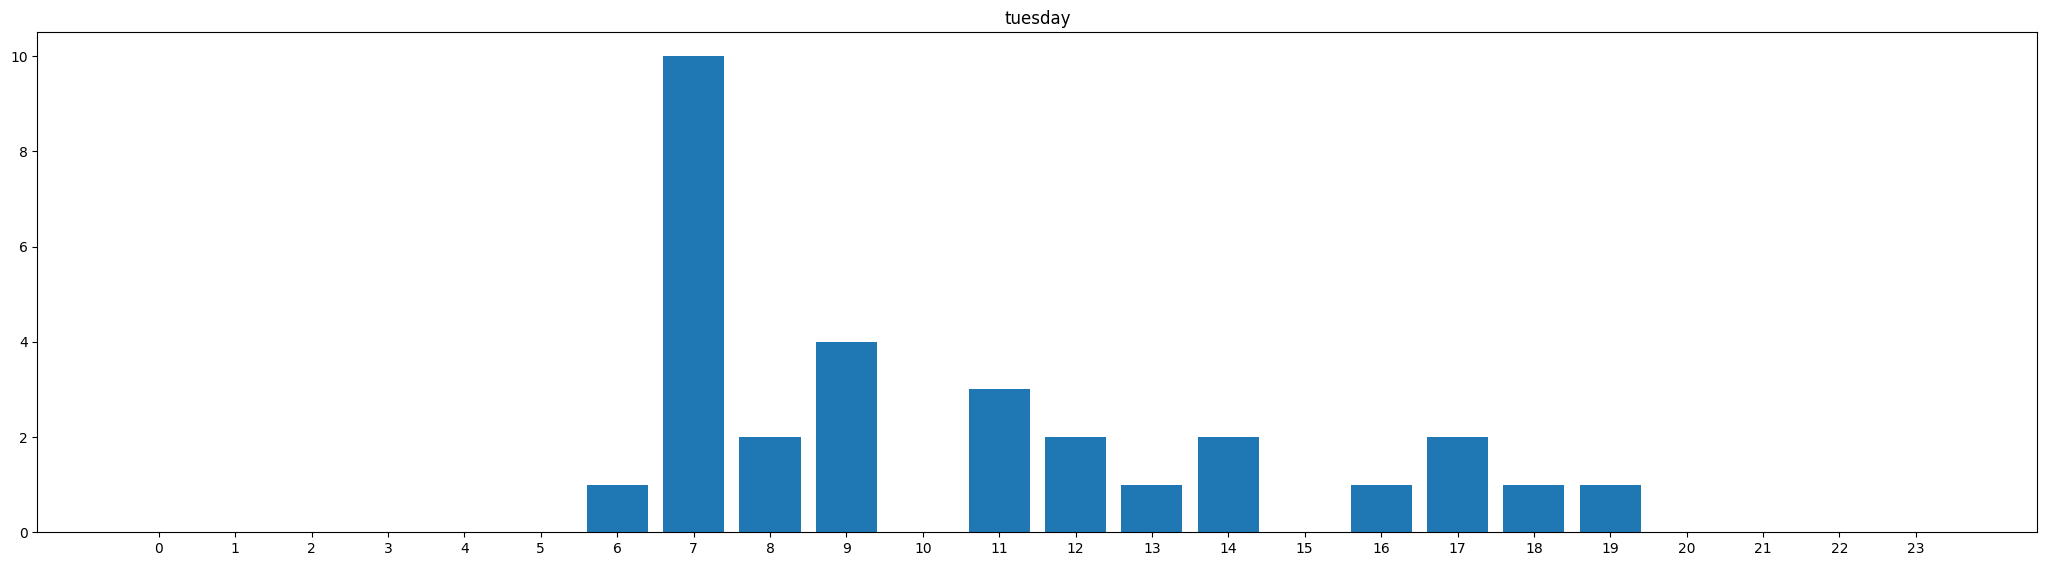

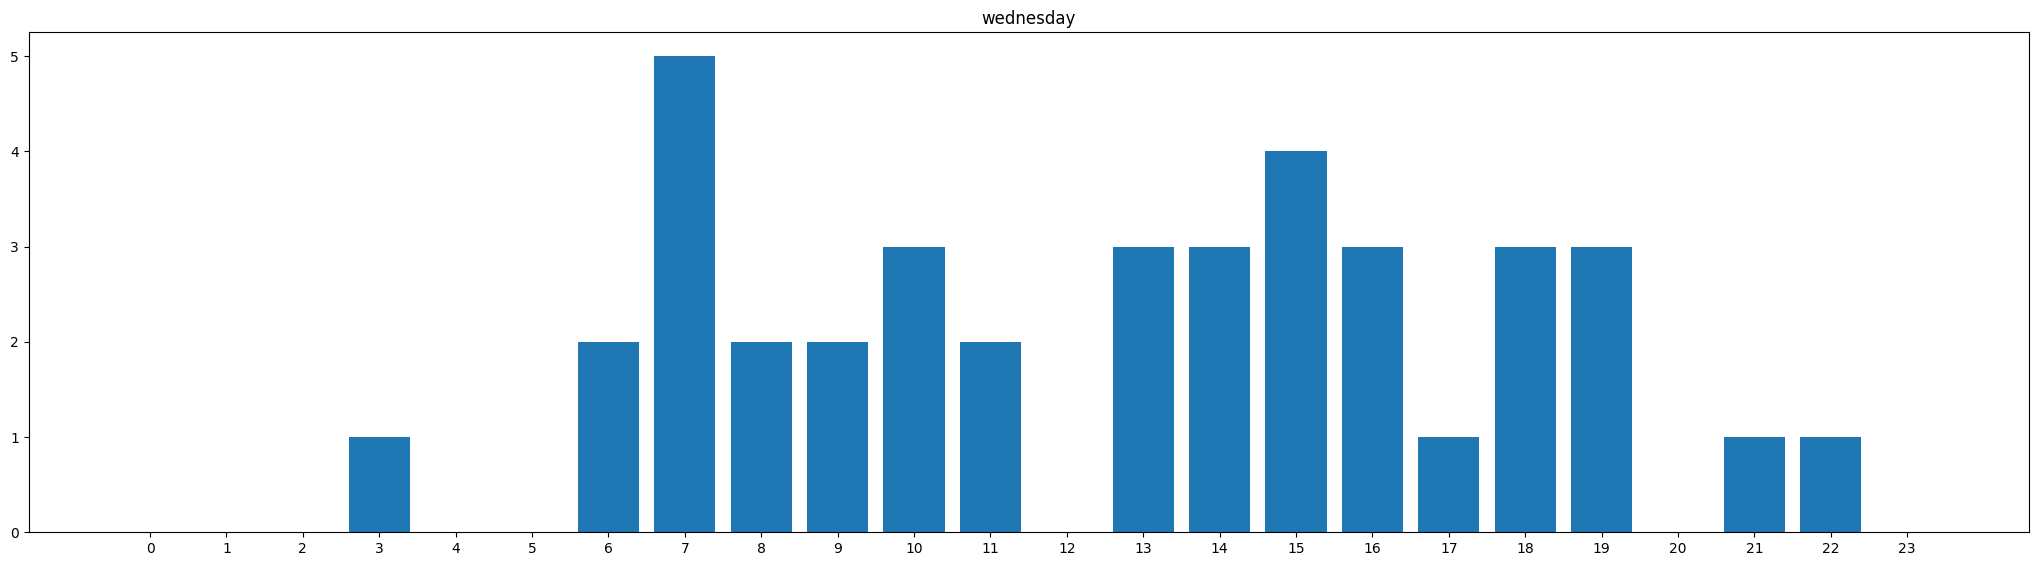

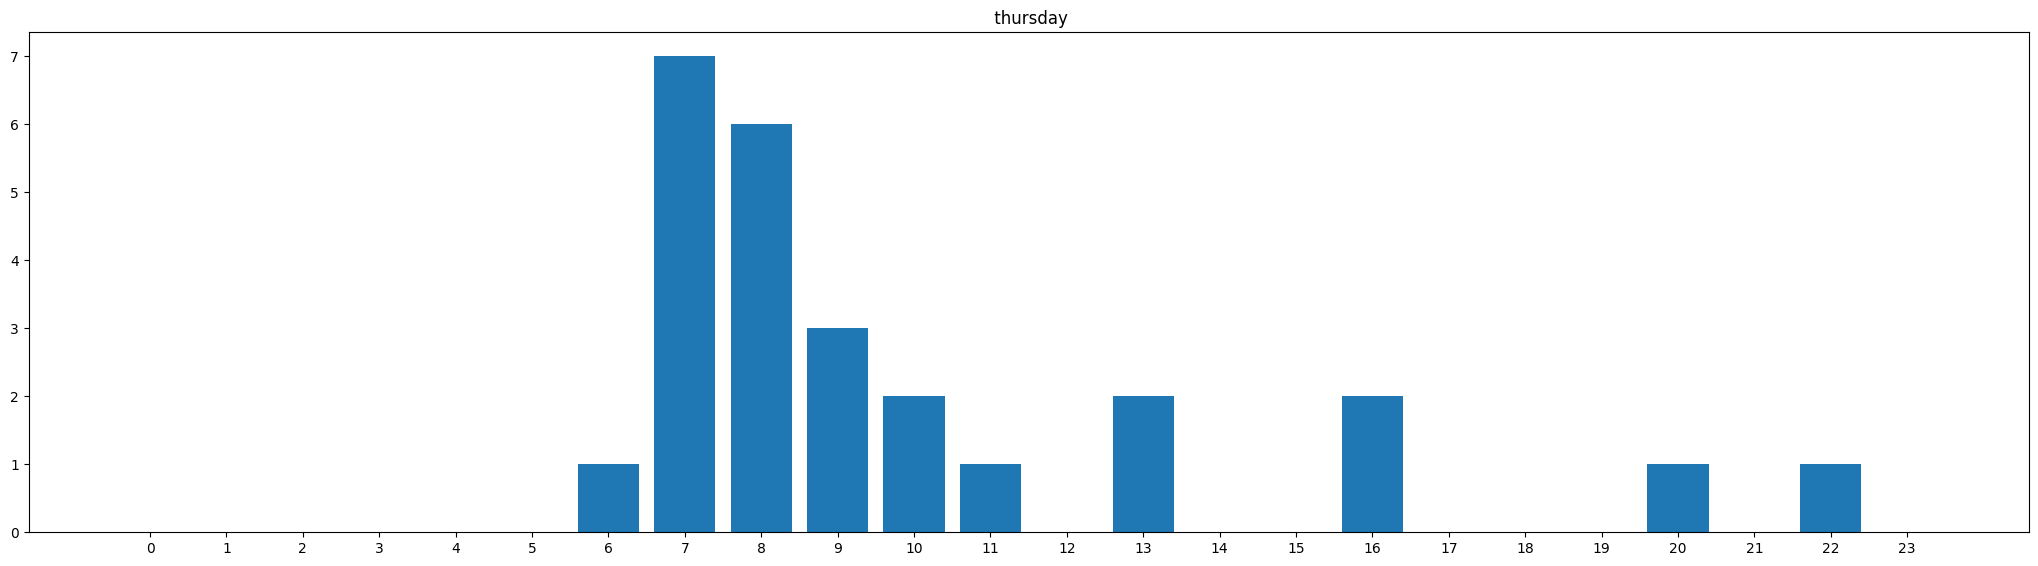

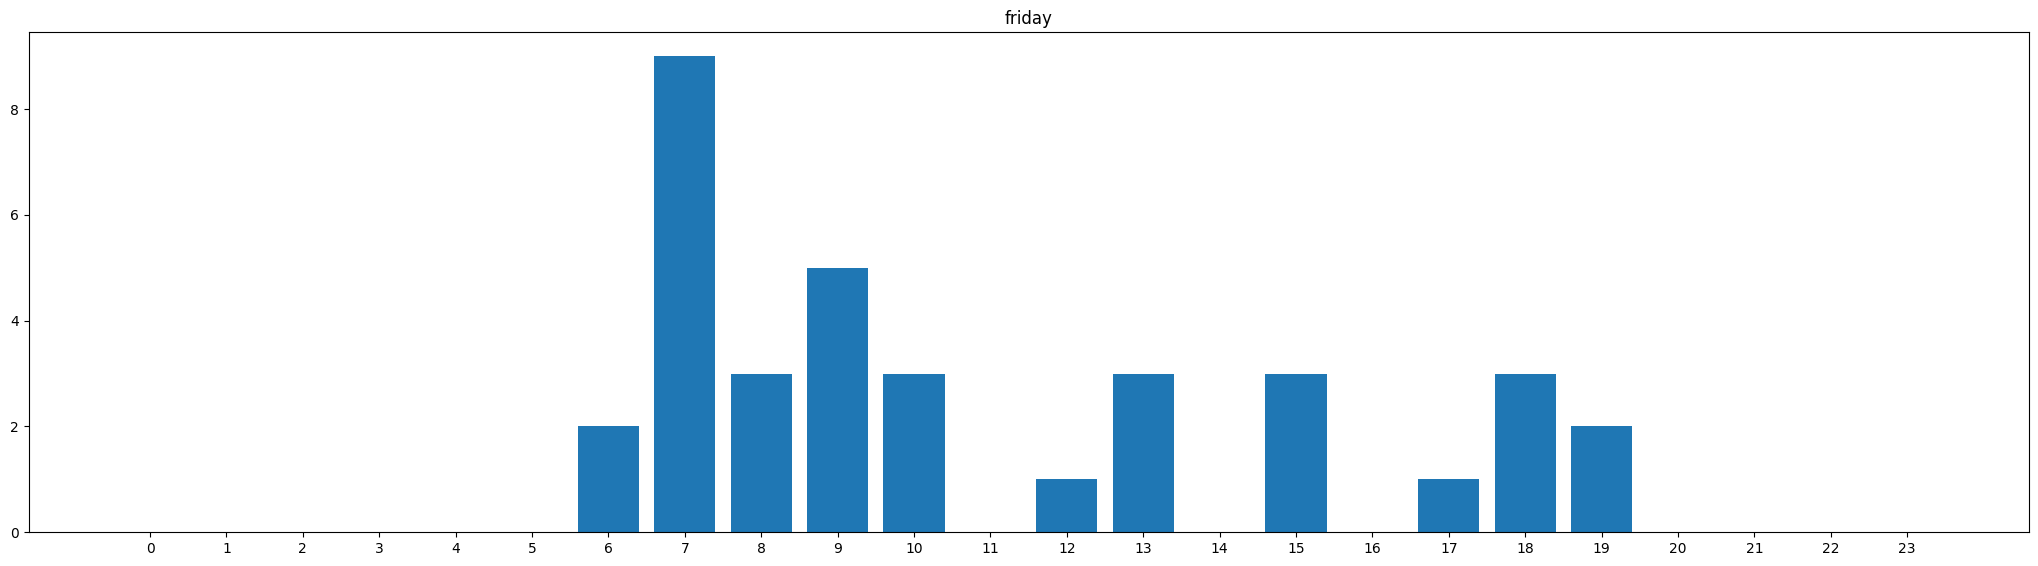

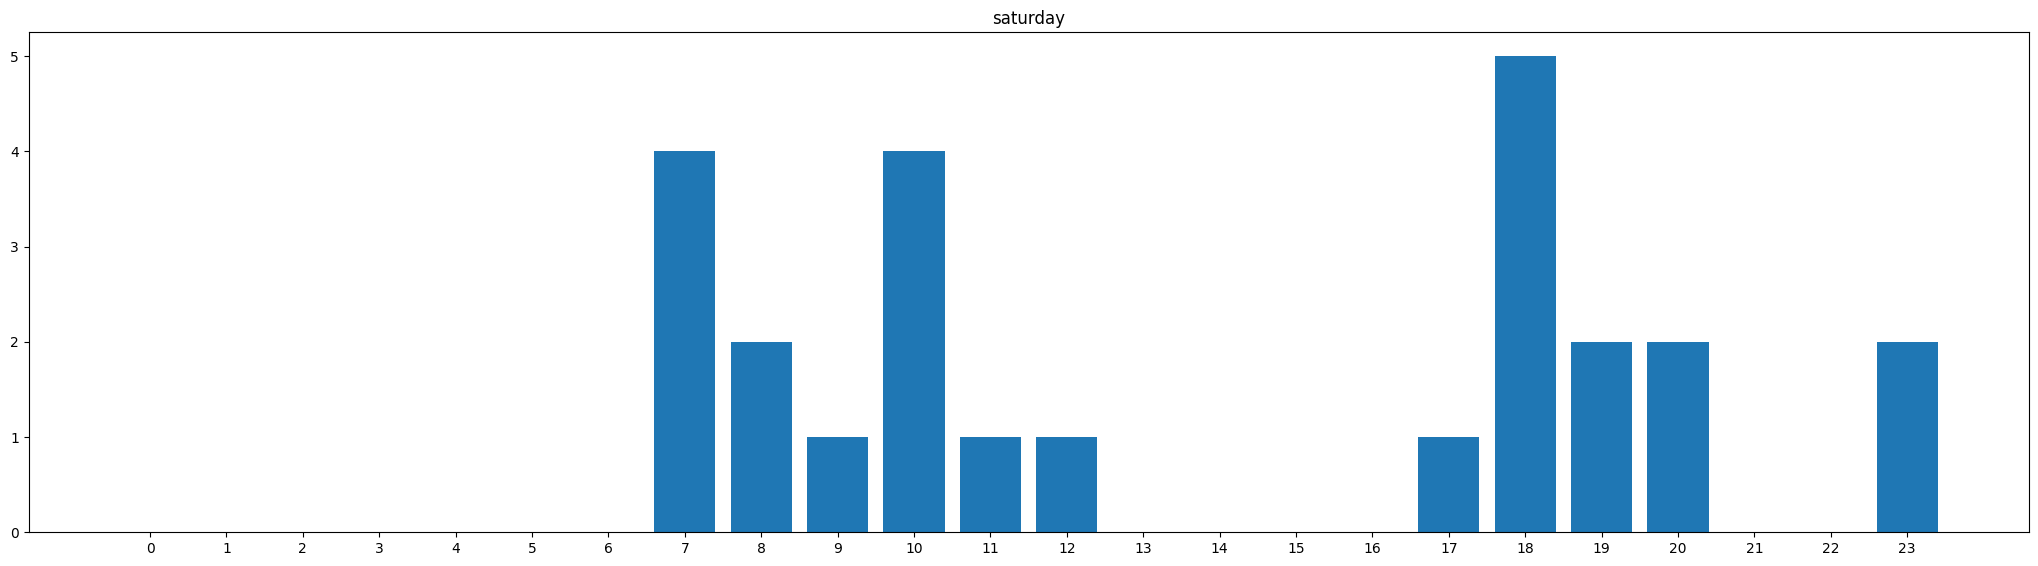

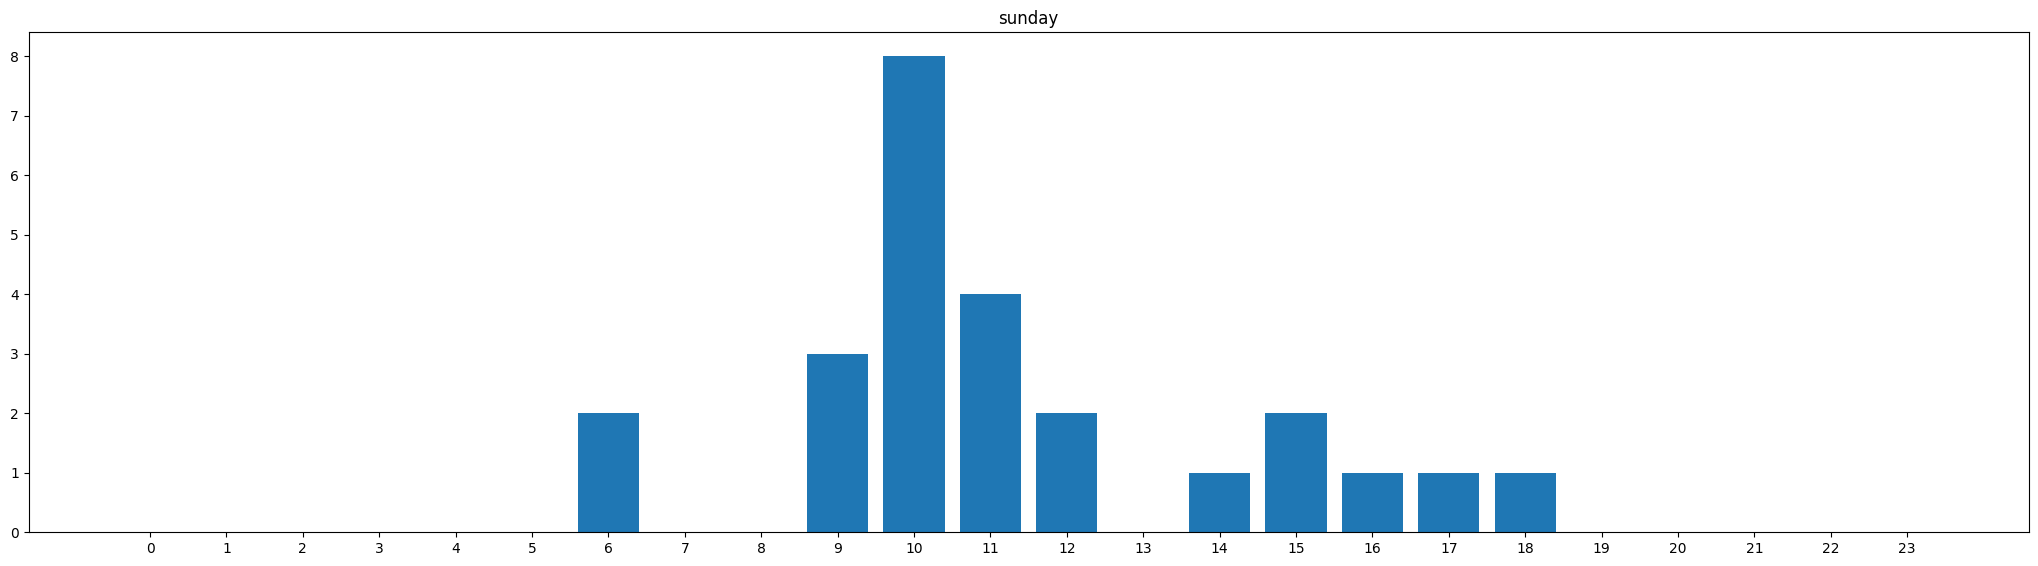

In [401]:
hours = list(range(24))
weekdays = ['monday', 'tuesday', 'wednesday', ' thursday', 'friday', 'saturday', 'sunday']

for i in range(7):
    figure = plt.figure(figsize=(20,5))

    axes = figure.add_axes([0,0,1,1])
    axes.set_title(weekdays[i])
    usage_by_hour = usage_by_hour_and_weekday[i * 24:i * 24 + 24]
    axes.bar(hours, usage_by_hour)
    plt.xticks(hours)

plt.show()